# Initiate the network

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from scipy.stats import linregress
from networkx.algorithms import bipartite
import random

Random_state = 42
random.seed(Random_state)

import os

## Utils

In [2]:
def print_network_data_statistics (G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.9f}")
    print(f"Max degree: {max(dict(G.degree()).values())}")
    print(f"Min degree: {min(dict(G.degree()).values())}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.0f}")
    print(f"Assortativity coefficient: {nx.degree_assortativity_coefficient(G):.7f}")
    node_triangles = nx.triangles(G)
    total_triangles = sum(node_triangles.values())
    print(f"Number of triangles: {total_triangles/1000:.1f}K")
    average_triangles_per_node = sum(nx.triangles(G).values()) / G.number_of_nodes()
    print(f"Average number of triangles: {average_triangles_per_node:.0f}")
    max_node_triangles = max(nx.triangles(G).values())
    print(f"Maximum number of triangles: {max_node_triangles/1000:.1f}K")
    print(f"Average clustering coefficient: {nx.average_clustering(G):.9f}")


    # You can inspect a few nodes and edges
    print("\nFirst 5 nodes:", list(G.nodes())[:5])
    print("First 5 edges:", list(G.edges())[:5])

In [3]:
from networkx.algorithms import bipartite
def sum_of_bipartite_edge_weights(graph, b1, b2):
    """
    Calculates the weight between two businesses (b1, b2) in the projected graph
    by summing the original 'weight' attributes of edges connecting their common users.

    The weight for each common user is the average of the 'weight' from user->b1 and user->b2.
    """
    projected_weight = 0
    common_users = set(graph.neighbors(b1)) & set(graph.neighbors(b2))

    if not common_users:
        return 0 # No shared users, no edge

    for user in common_users:
        # Get the weight from user to b1 and user to b2 from the original bipartite graph
        weight_b1 = graph[user][b1].get('weight', 0)
        weight_b2 = graph[user][b2].get('weight', 0)

        # Here you define how to combine the weights for each common user.
        # Examples:
        # 1. Sum of their individual weights for this user:
        #    projected_weight += weight_b1 + weight_b2
        # 2. Average of their individual weights for this user:
        #    projected_weight += (weight_b1 + weight_b2) / 2
        # 3. Product (if weights represent 'strength' that can multiply):
        #    projected_weight += weight_b1 * weight_b2
        # 4. Minimum (if you want the 'weakest link' of the shared connection):
        #    projected_weight += min(weight_b1, weight_b2)
        # 5. Maximum (if you want the 'strongest link'):
        #    projected_weight += max(weight_b1, weight_b2)
        # 6. For this example, let's stick with the "sum of averages" from previous:
        projected_weight += (weight_b1 + weight_b2) / 2

    return projected_weight

In [4]:
def largest_connected_component(G):
    components = nx.connected_components(G)
    largest = max(components, key=len)
    return G.subgraph(largest).copy(), components

## Load

In [5]:
# Path to your downloaded .txt.gz file
file_path = os.path.join( "data", "rec-yelp-user-business", "rec-yelp-user-business.edges")

expected NetworNetwork Data Statisticsk Data Statistics


![NetworNetwork Data Statisticsk Data Statistics](doc/rec-yelp-user-business-Network-Data-Statistics.png)

In [6]:
# Load graph yelp user business
try:
    G = nx.read_edgelist(file_path, data=(('weight', float),))
    print(f"Graph loaded successfully!")
    print_network_data_statistics(G)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please make sure you have downloaded it to the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")


Graph loaded successfully!
Number of nodes: 50395
Number of edges: 229636
Density: 0.000180844
Max degree: 846
Min degree: 1
Average degree: 9
Assortativity coefficient: -0.0930834
Number of triangles: 327.0K
Average number of triangles: 6
Maximum number of triangles: 3.5K
Average clustering coefficient: 0.011382921

First 5 nodes: ['1', '3', '4136', '4', '27']
First 5 edges: [('1', '1'), ('3', '3'), ('3', '4136'), ('3', '19'), ('3', '28')]


### Largest Connected Componnent

In [7]:
G_LCC, G_connected_component = largest_connected_component(G)

In [8]:
print_network_data_statistics(G_LCC)

Number of nodes: 50319
Number of edges: 229578
Density: 0.000181345
Max degree: 846
Min degree: 1
Average degree: 9
Assortativity coefficient: -0.0932319
Number of triangles: 327.0K
Average number of triangles: 6
Maximum number of triangles: 3.5K
Average clustering coefficient: 0.011400113

First 5 nodes: ['3', '4136', '4', '27', '46']
First 5 edges: [('3', '3'), ('3', '4136'), ('3', '19'), ('3', '28'), ('3', '50')]


## Sample 3100 edges

In [9]:
# Load graph yelp user business, sample 3100 edges, and print statistics
try:
    
    # Step 1: Load the edge list

    edges_df = pd.read_csv(file_path, sep='\s+', header=None, names=['user', 'business', 'weight'])
    sampled_edges_df = edges_df.sample(n=3100, random_state=Random_state)

    B = nx.Graph()

    # Add edges with weight as attribute
    for row in sampled_edges_df.itertuples(index=False):
        B.add_node(row.user, bipartite=0)       # Users
        B.add_node(row.business, bipartite=1)   # Businesses
        B.add_edge(row.user, row.business, weight=row.weight)

    # Step 3: Get node sets
    users = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
    businesses = set(B) - users
    
    print_network_data_statistics(B)
    
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please make sure you have downloaded it to the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")

Number of nodes: 4199
Number of edges: 3100
Density: 0.000351725
Max degree: 14
Min degree: 1
Average degree: 1
Assortativity coefficient: -0.0964571
Number of triangles: 0.0K
Average number of triangles: 0
Maximum number of triangles: 0.0K
Average clustering coefficient: 0.000000000

First 5 nodes: [1034, 1122, 4132, 2984, 1569]
First 5 edges: [(1034, 1122), (1034, 13375), (1034, 4329), (1034, 29968), (1034, 5019)]


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\pedro\AppData\Local\Temp\ipykernel_36756\2659897460.py:6: SyntaxWarning: invalid escape sequence '\s'
  edges_df = pd.read_csv(file_path, sep='\s+', header=None, names=['user', 'business', 'weight'])


In [10]:
print("Bipartite Graph Edges with 'weight' from your DataFrame:")
for u, v, data in B.edges(data=True):
    print(f"({u}, {v}, weight={data.get('weight', 'N/A')})")

Bipartite Graph Edges with 'weight' from your DataFrame:
(1034, 1122, weight=5)
(1034, 13375, weight=4)
(1034, 4329, weight=4)
(1034, 29968, weight=5)
(1034, 5019, weight=4)
(1034, 2246, weight=4)
(1122, 10685, weight=2)
(4132, 2984, weight=4)
(4132, 1220, weight=5)
(1569, 2126, weight=3)
(1569, 1276, weight=4)
(1569, 346, weight=4)
(1569, 24702, weight=4)
(1569, 2505, weight=5)
(2126, 177684, weight=5)
(2126, 4494, weight=5)
(3150, 6690, weight=4)
(42262, 7743, weight=3)
(7743, 61492, weight=4)
(7743, 11583, weight=5)
(7743, 1113, weight=5)
(8564, 166, weight=5)
(166, 11066, weight=2)
(166, 67617, weight=5)
(166, 104835, weight=3)
(166, 8394, weight=4)
(166, 9082, weight=2)
(166, 90993, weight=4)
(166, 59373, weight=4)
(166, 2195, weight=3)
(166, 26870, weight=4)
(21987, 340, weight=5)
(340, 36836, weight=3)
(340, 6280, weight=4)
(340, 303, weight=4)
(24367, 3566, weight=5)
(568, 505, weight=4)
(568, 184, weight=5)
(568, 1981, weight=4)
(568, 4429, weight=3)
(568, 8901, weight=3)
(568

### Sample Largest Connected Componnent

In [11]:
B_LCC, B_connected_component = largest_connected_component(B)

In [12]:
print_network_data_statistics(B_LCC)

Number of nodes: 438
Number of edges: 437
Density: 0.004566210
Max degree: 12
Min degree: 1
Average degree: 2
Assortativity coefficient: -0.2972207
Number of triangles: 0.0K
Average number of triangles: 0
Maximum number of triangles: 0.0K
Average clustering coefficient: 0.000000000

First 5 nodes: [12, 8208, 4113, 2064, 17]
First 5 edges: [(12, 284), (12, 1846), (8208, 1130), (4113, 3039), (4113, 258)]


## Business
### One mode projection

In [13]:
G_business_Sample = bipartite.generic_weighted_projected_graph(
    B, businesses, weight_function=sum_of_bipartite_edge_weights
)

print("\nProjected Business-Business Graph Edges with custom weights:")
for u, v, data in G_business_Sample.edges(data=True):
    print(f"({u}, {v}, weight={data.get('weight', 'N/A')})")

# --- Step 4: Validate the weights (using the methods from the previous answer) ---
print("\n--- Validation of Projected Weights ---")
all_edge_attributes = nx.get_edge_attributes(G_business_Sample, 'weight')
print(f"All projected edge weights: {all_edge_attributes}")


Projected Business-Business Graph Edges with custom weights:
(4, 3360, weight=2.5)
(4, 25906, weight=3.5)
(4, 2363, weight=4.0)
(6, 6944, weight=5.0)
(6, 1507, weight=5.0)
(6, 1573, weight=3.5)
(6, 10250, weight=5.0)
(6, 979, weight=3.5)
(7, 15910, weight=5.0)
(8, 4257, weight=3.5)
(8, 9640, weight=4.0)
(8, 346, weight=3.5)
(8, 6550, weight=3.5)
(8, 5338, weight=4.0)
(10, 2463, weight=4.5)
(10, 50, weight=3.0)
(10, 2015, weight=3.5)
(15, 2234, weight=3.5)
(15, 2124, weight=3.0)
(17, 302, weight=4.0)
(22, 1763, weight=4.5)
(22, 56675, weight=5.0)
(22, 869, weight=4.0)
(22, 201, weight=4.0)
(22, 117035, weight=4.5)
(21, 8576, weight=1.5)
(21, 2512, weight=2.0)
(21, 1969, weight=2.5)
(21, 3729, weight=2.0)
(21, 247, weight=3.5)
(21, 7035, weight=3.5)
(26, 206597, weight=3.0)
(26, 1351, weight=3.5)
(26, 133609, weight=4.5)
(26, 6730, weight=4.5)
(26, 1867, weight=5.0)
(26, 568, weight=4.0)
(26, 70669, weight=5.0)
(26, 12909, weight=3.5)
(26, 4495, weight=2.0)
(26, 1103, weight=4.0)
(26, 6

In [14]:
print_network_data_statistics(G_business_Sample)

Number of nodes: 2501
Number of edges: 2043
Density: 0.000653499
Max degree: 21
Min degree: 0
Average degree: 2
Assortativity coefficient: 0.1991399
Number of triangles: 4.3K
Average number of triangles: 2
Maximum number of triangles: 0.1K
Average clustering coefficient: 0.224307522

First 5 nodes: [8192, 3, 4, 6, 7]
First 5 edges: [(4, 3360), (4, 25906), (4, 2363), (6, 6944), (6, 1507)]


### Sample Largest Connected Componnent

In [15]:
G_business_Sample_LCC, G_business_Sample_connected_component = largest_connected_component(G_business_Sample)

In [16]:
print_network_data_statistics(G_business_Sample_LCC)

Number of nodes: 112
Number of edges: 195
Density: 0.031370656
Max degree: 18
Min degree: 1
Average degree: 3
Assortativity coefficient: -0.2073167
Number of triangles: 0.5K
Average number of triangles: 4
Maximum number of triangles: 0.0K
Average clustering coefficient: 0.401826609

First 5 nodes: [1540, 7693, 70669, 8208, 1041]
First 5 edges: [(1540, 575), (1540, 1112), (1540, 6225), (1540, 39785), (7693, 4113)]


## Users
### One mode projection

In [17]:
G_Users_Sample = bipartite.generic_weighted_projected_graph(
    B, users, weight_function=sum_of_bipartite_edge_weights
)

print("\nProjected Business-Business Graph Edges with custom weights:")
for u, v, data in G_users.edges(data=True):
    print(f"({u}, {v}, weight={data.get('weight', 'N/A')})")

# --- Step 4: Validate the weights (using the methods from the previous answer) ---
print("\n--- Validation of Projected Weights ---")
all_edge_attributes = nx.get_edge_attributes(G_users, 'weight')
print(f"All projected edge weights: {all_edge_attributes}")


Projected Business-Business Graph Edges with custom weights:


NameError: name 'G_users' is not defined

In [ ]:
print_network_data_statistics(G_Users_Sample)

Number of nodes: 2936
Number of edges: 3312
Density: 0.000768699
Max degree: 18
Min degree: 0
Average degree: 2
Assortativity coefficient: 0.5124589
Number of triangles: 10.9K
Average number of triangles: 4
Maximum number of triangles: 0.1K
Average clustering coefficient: 0.368218155

First 5 nodes: [5, 106501, 131079, 8201, 11]
First 5 edges: [(106501, 17812), (8201, 1680), (11, 9216), (11, 676), (11, 45832)]


### Sample Largest Connected Componnent

In [ ]:
G_Users_Sample_LCC, G_Users_Sample_connected_component = largest_connected_component(G_Users_Sample)

In [ ]:
print_network_data_statistics(G_Users_Sample_LCC)

Number of nodes: 150
Number of edges: 289
Density: 0.025861298
Max degree: 18
Min degree: 1
Average degree: 4
Assortativity coefficient: -0.1628990
Number of triangles: 0.7K
Average number of triangles: 5
Maximum number of triangles: 0.0K
Average clustering coefficient: 0.611778963

First 5 nodes: [516, 6662, 27658, 2064, 1557]
First 5 edges: [(516, 184), (6662, 236), (6662, 354), (6662, 2449), (6662, 3039)]


# 2: Centrality Measures

### 2.1 Degree Centrality.

In [ ]:
def plot_degree_centrality(G_analysis, title="Degree Centrality Distribution",
                        plot_graph_sample=True, sample_nodes_for_draw=150, draw_layout_iterations=50):
    """
    Plots the degree centrality distribution of a graph G_analysis.
    If the graph is disconnected, it calculates degree centrality for the Largest Connected Component (LCC).
    if the graph is empty, it will not attempt to calculate or plot degree centrality.
    If plot_graph_sample is True, it will attempt to plot a sample of the graph with nodes colored by degree centrality.
    
    Parameters:
    G_analysis: NetworkX graph object - the graph to analyze. 
    title: str - title for the plot.
    plot_graph_sample: bool - whether to plot a sample of the graph with nodes colored by degree centrality.
    sample_nodes_for_draw: int - number of nodes to sample for drawing the graph.
    draw_layout_iterations: int - number of iterations for the layout algorithm when plotting the graph sample.
    """
    if G.number_of_nodes() == 0:
        print("Graph is empty. Cannot calculate or plot degree centrality.")
        return
    
    degree_centrality = nx.degree_centrality(G_analysis)
    centrality_values = list(degree_centrality.values())
    
    if centrality_values:
        max_dc = max(centrality_values)
        min_dc = min(centrality_values)
        avg_dc = sum(centrality_values) / len(centrality_values)
        
        print(f"\n--- Degree Centrality Analysis ---")
        print(f"Graph analyzed (LCC if disconnected): Nodes={G_analysis.number_of_nodes()}, Edges={G_analysis.number_of_edges()}")
        print(f"Maximum Degree Centrality: {max_dc:.6f}")
        print(f"Minimum Degree Centrality: {min_dc:.6f}")
        print(f"Average Degree Centrality: {avg_dc:.6f}")
        print(f"------------------------------------------------------------------------")
    else:
        print("\nNo degree centrality values to display (e.g., graph has no nodes/edges in LCC).")
    
    plt.figure(figsize=(8, 5))
    plt.hist(centrality_values, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Degree Centrality", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="major", ls="--", c='0.8')
    plt.tight_layout()
    plt.show()
    
    if plot_graph_sample and G_analysis.number_of_nodes() > 0:
        print(f"\nAttempting to plot a sample of the graph (N={sample_nodes_for_draw}) with nodes colored by degree centrality...")

        G_draw_nodes = []
        if G_analysis.number_of_nodes() > sample_nodes_for_draw:
            G_draw_nodes = random.sample(list(G_analysis.nodes()), sample_nodes_for_draw)
            G_sample_for_draw = G_analysis.subgraph(G_draw_nodes).copy()
            print(f"  - Drawing a random sample of {sample_nodes_for_draw} nodes and their internal edges.")
        else:
            # If the LCC is already small enough, draw the whole LCC
            G_sample_for_draw = G_analysis
            sample_nodes_for_draw_actual = G_analysis.number_of_nodes()
            print(f"  - Drawing the entire Largest Connected Component ({sample_nodes_for_draw_actual} nodes).")

        if G_sample_for_draw.number_of_nodes() == 0:
            print("  - No nodes to draw in the selected sample/LCC.")
            return

        # Prepare node colors and sizes based on degree centrality for the sample
        sample_centrality_values = [degree_centrality.get(node, 0) for node in G_sample_for_draw.nodes()]
        
        # Scale node sizes for better visibility
        if sample_centrality_values and max(sample_centrality_values) > 0:
            max_val = max(sample_centrality_values)
            node_sizes = [50 + 1000 * (val / max_val) for val in sample_centrality_values]
        else: 
            node_sizes = [50] * len(G_sample_for_draw.nodes()) 
            
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G_sample_for_draw, k=0.1, iterations=draw_layout_iterations, seed=42)
        # Draw the graph elements
        nodes = nx.draw_networkx_nodes(G_sample_for_draw, pos,
                                        node_color=sample_centrality_values,
                                        node_size=node_sizes,
                                        cmap=plt.cm.cividis,
                                        alpha=0.8)
        nx.draw_networkx_edges(G_sample_for_draw, pos,
                                edge_color='gray', alpha=0.4, width=0.5)

        plt.title(f"Graph Sample (N={len(G_sample_for_draw.nodes())}) with Node Degree Centrality", fontsize=14)
        
        if nodes is not None:
            plt.colorbar(nodes, ax=plt.gca(), label="Normalized Degree Centrality")
        
        plt.axis('off')
        plt.show()
    elif plot_graph_sample:
        print("\nGraph sample cannot be plotted: The graph (or LCC) is empty or too small.")


#### Sample network


--- Degree Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=438, Edges=437
Maximum Degree Centrality: 0.027460
Minimum Degree Centrality: 0.002288
Average Degree Centrality: 0.004566
------------------------------------------------------------------------


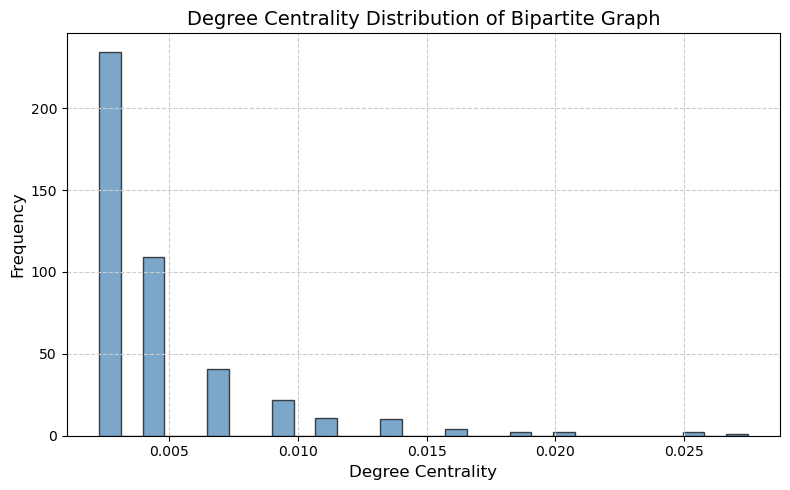


Attempting to plot a sample of the graph (N=500) with nodes colored by degree centrality...
  - Drawing the entire Largest Connected Component (438 nodes).


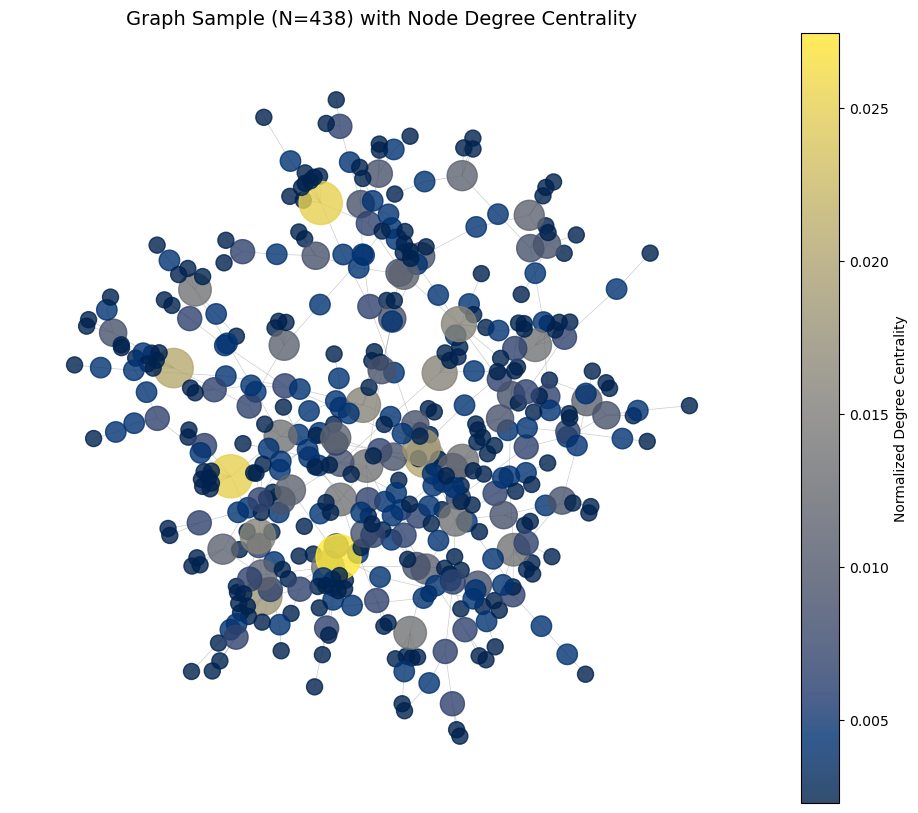

In [ ]:
plot_degree_centrality(B_LCC, title="Degree Centrality Distribution of Bipartite Graph",
                        plot_graph_sample=True, sample_nodes_for_draw=500, draw_layout_iterations=50)

#### Business Projection network


--- Degree Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=112, Edges=195
Maximum Degree Centrality: 0.162162
Minimum Degree Centrality: 0.009009
Average Degree Centrality: 0.031371
------------------------------------------------------------------------


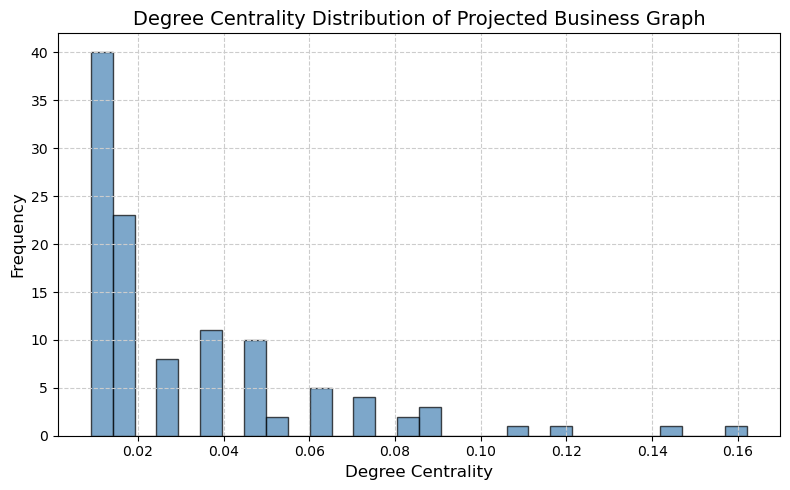


Attempting to plot a sample of the graph (N=750) with nodes colored by degree centrality...
  - Drawing the entire Largest Connected Component (112 nodes).


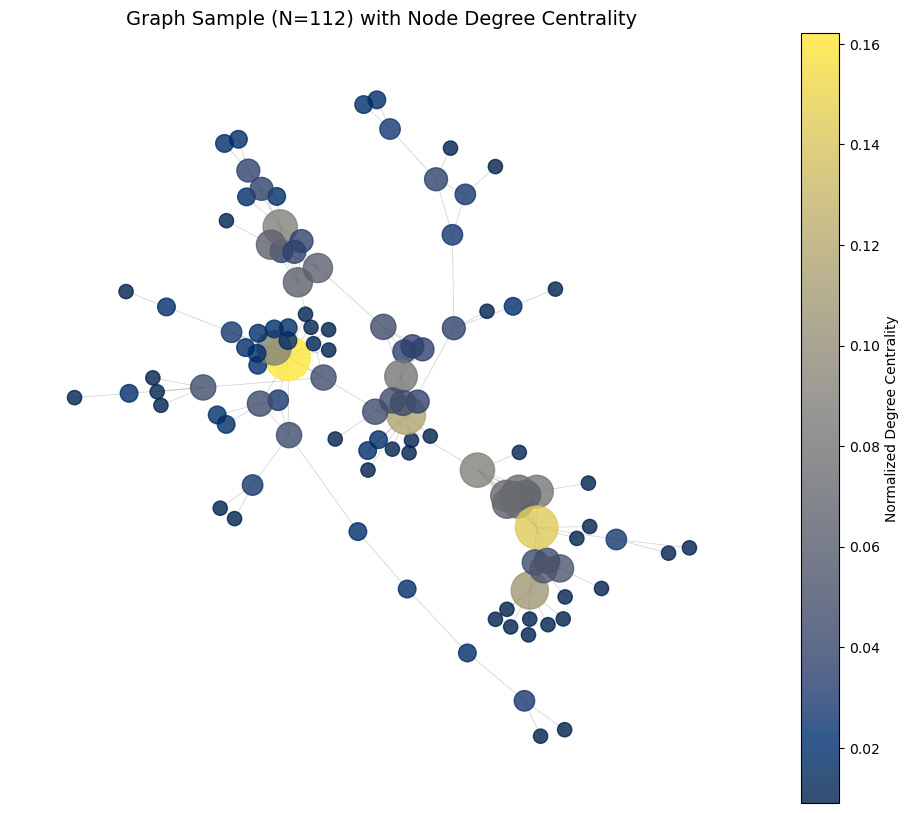

In [ ]:
plot_degree_centrality(G_business_Sample_LCC, 
                        title="Degree Centrality Distribution of Projected Business Graph",
                        plot_graph_sample=True, sample_nodes_for_draw=750, draw_layout_iterations=50)

#### Users Projection network


--- Degree Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=150, Edges=289
Maximum Degree Centrality: 0.120805
Minimum Degree Centrality: 0.006711
Average Degree Centrality: 0.025861
------------------------------------------------------------------------


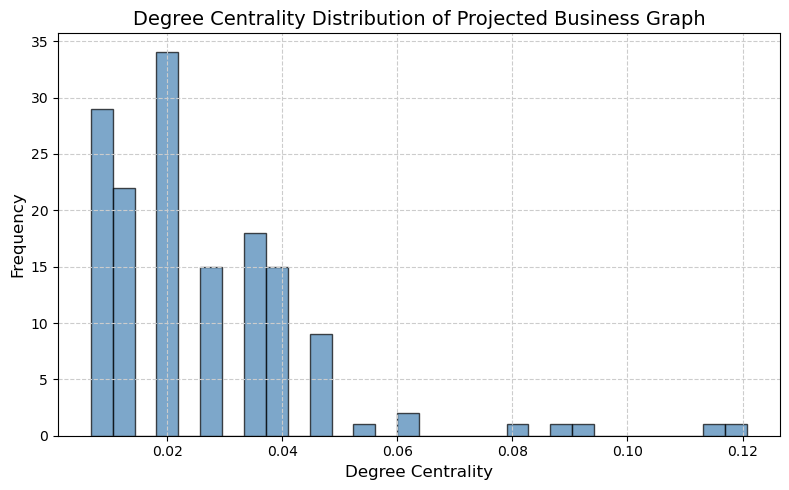


Attempting to plot a sample of the graph (N=750) with nodes colored by degree centrality...
  - Drawing the entire Largest Connected Component (150 nodes).


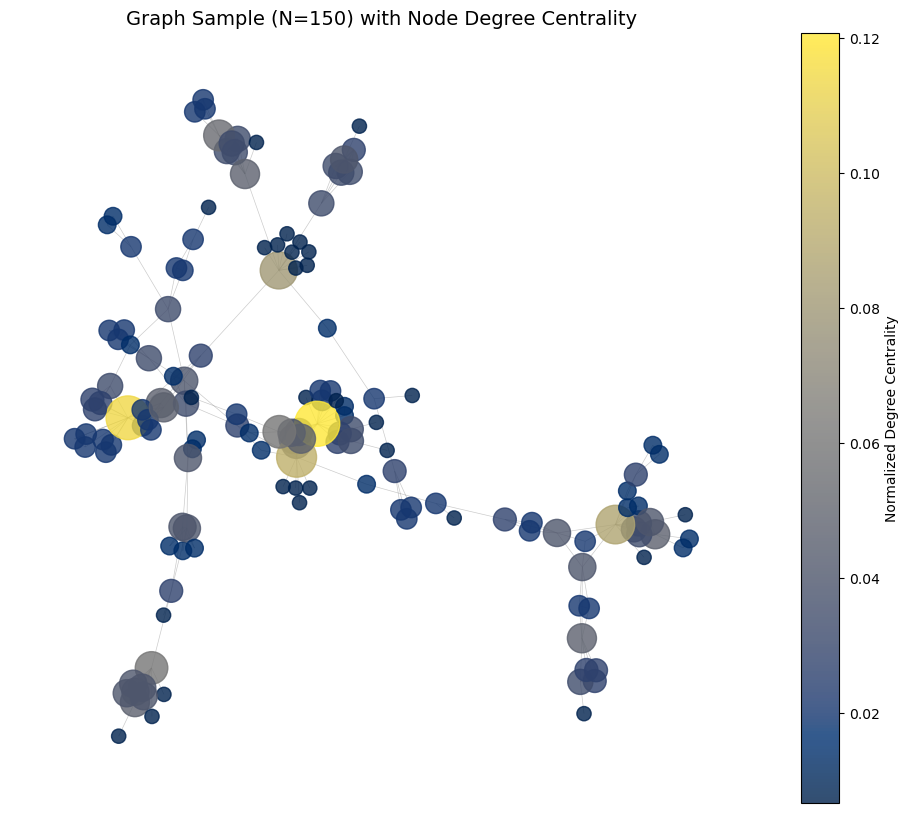

In [ ]:
plot_degree_centrality(G_Users_Sample_LCC, 
                        title="Degree Centrality Distribution of Projected Business Graph",
                        plot_graph_sample=True, sample_nodes_for_draw=750, draw_layout_iterations=50)

### 2.2 Betweenness Centrality

In [ ]:
def print_betweenness_centrality(G):
    non_normalized_betweenness = nx.betweenness_centrality(G, normalized=False)
    normalized_betweenness = nx.betweenness_centrality(G, normalized=True)
    
    print(f"Non-normalized Betweenness Centrality:")
    print(f"Max Betweenness Centrality:{max(non_normalized_betweenness.values()):.0f}")
    print(f"min Betweenness Centrality:{min(non_normalized_betweenness.values()):.0f}")
    average_non_normalized_betweenness = sum(non_normalized_betweenness.values()) / len(non_normalized_betweenness)
    print(f"average Betweenness Centrality:{average_non_normalized_betweenness:.6f}")
    print(f"------------------------------------------------------------------------")
    print(f"Normalized Betweenness Centrality:")
    print(f"Max Betweenness Centrality:{max(normalized_betweenness.values()):.6f}")
    print(f"min Betweenness Centrality:{min(normalized_betweenness.values()):.6f}")
    average_normalized_betweenness = sum(normalized_betweenness.values()) / len(normalized_betweenness)
    print(f"average Betweenness Centrality:{average_normalized_betweenness:.6f}")
    
    # --- Plotting the Betweenness Centrality Distribution ---
    
    # Get the centrality values for plotting
    normalized_values = list(normalized_betweenness.values())
    
    node_colors = [normalized_betweenness.get(node, 0) for node in G.nodes()] 
    node_sizes = [20 + 500 * (normalized_betweenness.get(node, 0) / max(node_colors)) for node in G.nodes()]
    
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.viridis, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4, width=0.5)
    
    
    plt.title(f"Graph of Node Betweenness Centrality", fontsize=14)
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), label="Normalized Betweenness Centrality")
    plt.axis('off') # Turn off the axis
    plt.show()

#### Sample network

Non-normalized Betweenness Centrality:
Max Betweenness Centrality:63575.000000
min Betweenness Centrality:0.000000
average Betweenness Centrality:3316.454338
------------------------------------------------------------------------
Normalized Betweenness Centrality:
Max Betweenness Centrality:0.667342
min Betweenness Centrality:0.000000
average Betweenness Centrality:0.034813


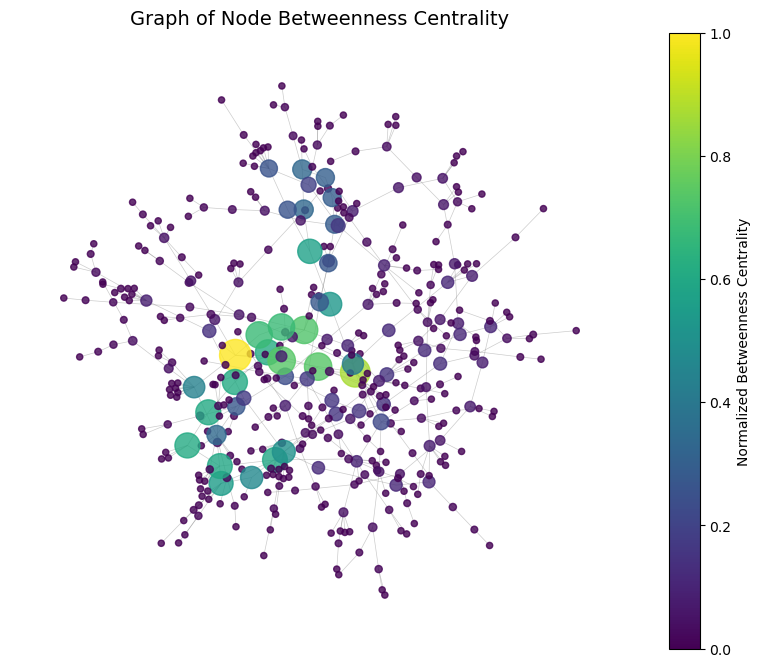

In [ ]:
print_betweenness_centrality(B_LCC)

#### Business Projection network


Non-normalized Betweenness Centrality:
Max Betweenness Centrality:4244.000000
min Betweenness Centrality:0.000000
average Betweenness Centrality:284.303571
------------------------------------------------------------------------
Normalized Betweenness Centrality:
Max Betweenness Centrality:0.695168
min Betweenness Centrality:0.000000
average Betweenness Centrality:0.046569


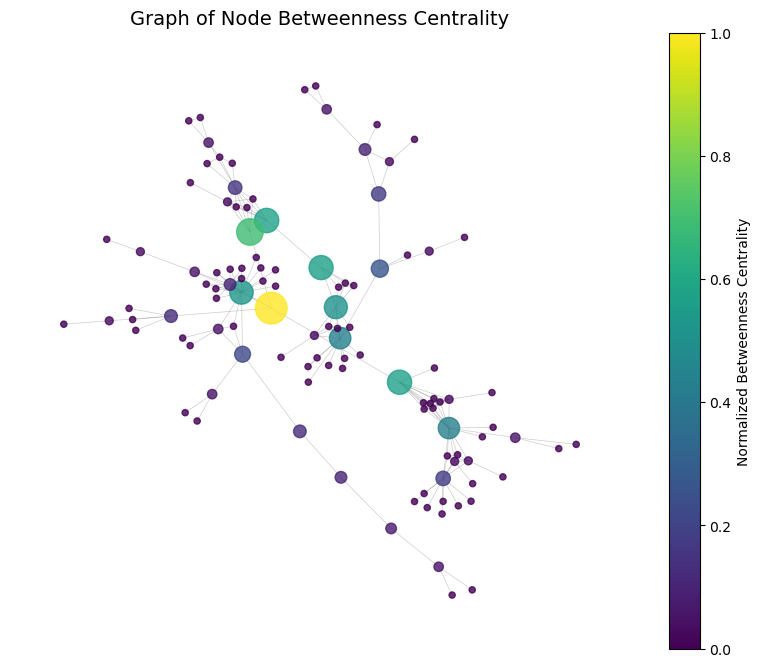

In [ ]:
print_betweenness_centrality(G_business_Sample_LCC)

#### Users Projection network


Non-normalized Betweenness Centrality:
Max Betweenness Centrality:6329.166667
min Betweenness Centrality:0.000000
average Betweenness Centrality:551.033333
------------------------------------------------------------------------
Normalized Betweenness Centrality:
Max Betweenness Centrality:0.574022
min Betweenness Centrality:0.000000
average Betweenness Centrality:0.049976


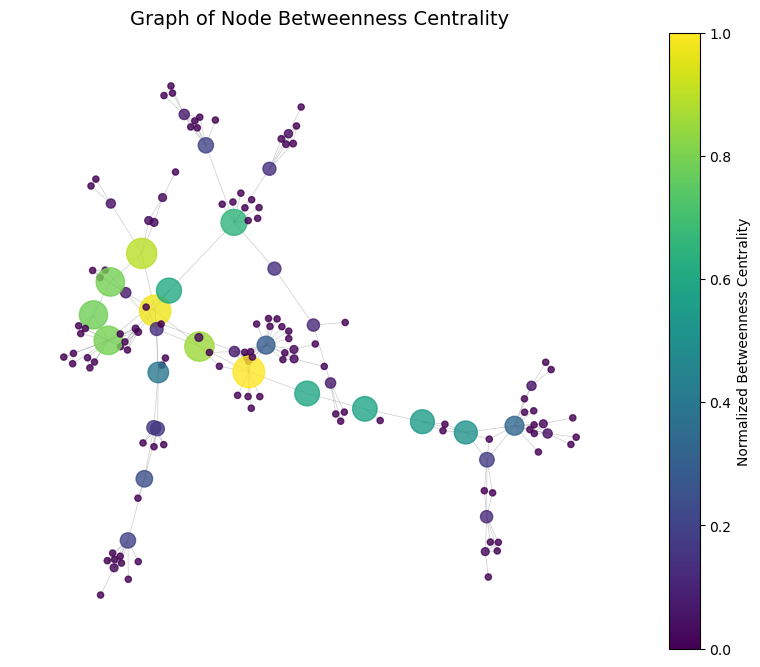

In [ ]:
print_betweenness_centrality(G_Users_Sample_LCC)

### 2.3  Closeness Centrality.

In [ ]:
def print_closeness_centrality(G):
    closeness_centrality = nx.closeness_centrality(G)
    
    print(f"Max Closeness Centrality: {max(closeness_centrality.values()):.6f}")
    print(f"Min Closeness Centrality: {min(closeness_centrality.values()):.6f}")
    average_closeness = sum(closeness_centrality.values()) / len(closeness_centrality)
    print(f"Average Closeness Centrality: {average_closeness:.6f}")
    
    # --- Plotting the Closeness Centrality Distribution ---
    
    node_colors = [closeness_centrality.get(node, 0) for node in G.nodes()] 
    node_sizes = [20 + 500 * (closeness_centrality.get(node, 0) / max(node_colors)) for node in G.nodes()]
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.1, iterations=50, seed=42)
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, cmap=plt.cm.viridis, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4, width=0.5)
    
    plt.title(f"Graph of Node Closeness Centrality", fontsize=14)
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.viridis), ax=plt.gca(), label="Closeness Centrality")
    plt.axis('off') # Turn off the axis
    plt.show()

#### Sample network

Max Closeness Centrality: 0.100367
Min Closeness Centrality: 0.037459
Average Closeness Centrality: 0.064478


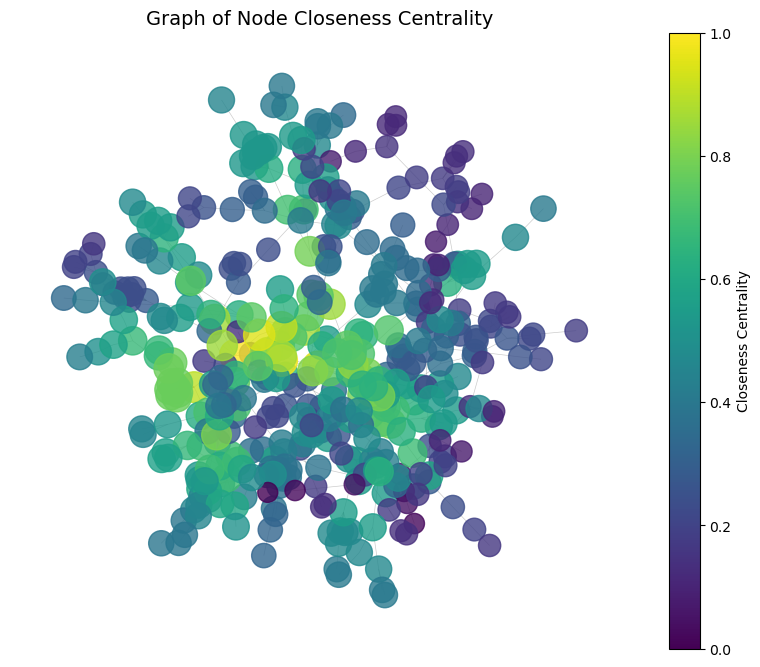

In [ ]:
print_closeness_centrality(B_LCC)

#### Business Projection network

Max Closeness Centrality: 0.265550
Min Closeness Centrality: 0.096104
Average Closeness Centrality: 0.170674


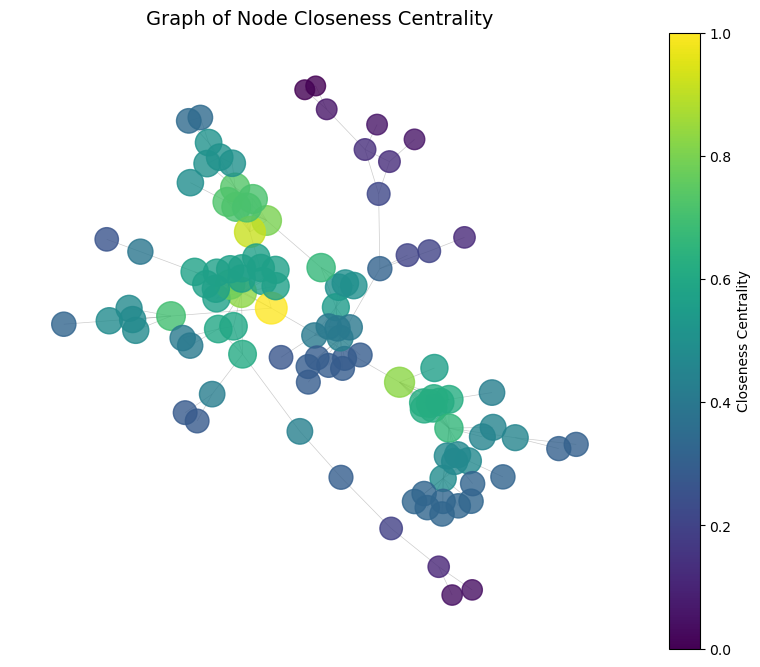

In [ ]:
print_closeness_centrality(G_business_Sample_LCC)

#### Users Projection network

Max Closeness Centrality: 0.183951
Min Closeness Centrality: 0.084852
Average Closeness Centrality: 0.123111


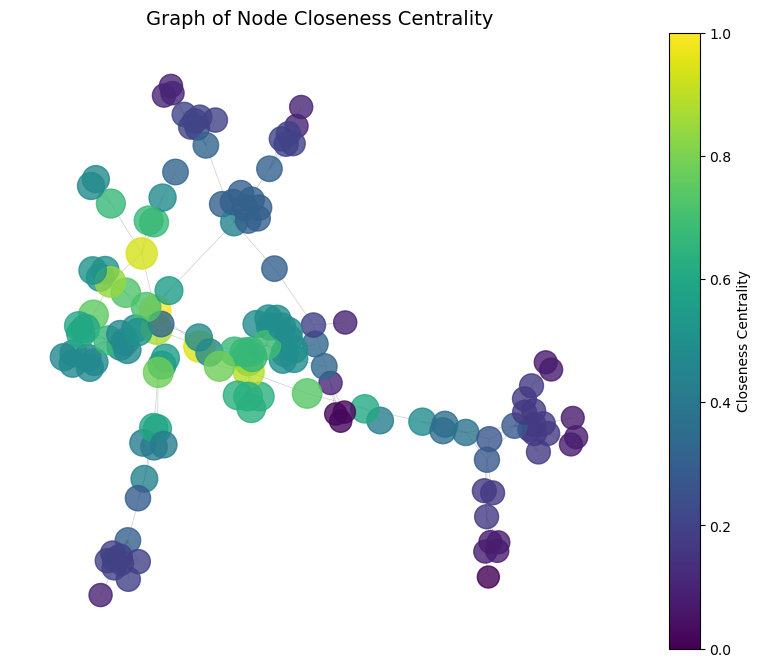

In [ ]:
print_closeness_centrality(G_Users_Sample_LCC)

### 2.4  Eigenvector Centrality.

In [ ]:
def plot_eigenvector_centrality(G_analysis, title="Eigenvector Centrality Distribution",
                                plot_graph_sample=True, 
                                sample_nodes_for_draw=150, draw_layout_iterations=50):
    """
    Plots the eigenvector centrality of a graph G.
    """
    
    if G.number_of_nodes() == 0:
        print("Graph is empty. Cannot calculate or plot eigenvector centrality.")
        return
    
    if G_analysis.number_of_nodes() == 0 or G_analysis.number_of_edges() == 0:
        print("Largest Connected Component has no nodes or no edges. Eigenvector centrality cannot be computed meaningfully.")
        return

    # Compute eigenvector centrality
    try:
        centrality = nx.eigenvector_centrality(G_analysis, max_iter=2000, tol=1e-06)
    except nx.NetworkXError as e:
        print(f"\nError computing Eigenvector Centrality: {e}")
        print("This can happen if the graph is disconnected (and the LCC still has issues), or if the graph has no edges.")
        return
    except Exception as e:
        print(f"\nAn unexpected error occurred during eigenvector centrality calculation: {e}")
        return
    
    centrality_values = list(centrality.values())

    if centrality_values:
        max_ec = max(centrality_values)
        min_ec = min(centrality_values)
        avg_ec = sum(centrality_values) / len(centrality_values)
        
        print(f"\n--- Eigenvector Centrality Analysis ---")
        print(f"Graph analyzed (LCC if disconnected): Nodes={G_analysis.number_of_nodes()}, Edges={G_analysis.number_of_edges()}")
        print(f"Maximum Eigenvector Centrality: {max_ec:.6f}")
        print(f"Minimum Eigenvector Centrality: {min_ec:.6f}")
        print(f"Average Eigenvector Centrality: {avg_ec:.6f}")
        print(f"------------------------------------------------------------------------")
    else:
        print("\nNo eigenvector centrality values to display (e.g., LCC has no relevant structure).")
        return 

    plt.figure(figsize=(10, 6))
    plt.hist(centrality_values, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)

    plt.xlabel("Eigenvector Centrality (log scale)", fontsize=12)
    plt.ylabel("Frequency (Number of Nodes) (log scale)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="major", ls="--", c='0.8')
    
    # filter out 0s for log scaling
    non_zero_values = [v for v in centrality_values if v > 0]
    if len(non_zero_values) > 0 and (max(non_zero_values) / min(non_zero_values) > 100): # Only use log x if range is wide
        plt.xscale('log')
    
    plt.yscale('log') 
    plt.tight_layout()
    plt.show()
    
    # --- Implementing nx.draw for a sample of the graph ---
    if plot_graph_sample and G_analysis.number_of_nodes() > 0:
        print(f"\nAttempting to plot a sample of the graph (N={sample_nodes_for_draw}) with nodes colored by eigenvector centrality...")

        G_draw_nodes = []
        if G_analysis.number_of_nodes() > sample_nodes_for_draw:
            G_draw_nodes = random.sample(list(G_analysis.nodes()), sample_nodes_for_draw)
            G_sample_for_draw = G_analysis.subgraph(G_draw_nodes).copy()
            print(f"  - Drawing a random sample of {sample_nodes_for_draw} nodes and their internal edges.")
        else:
            G_sample_for_draw = G_analysis
            sample_nodes_for_draw_actual = G_analysis.number_of_nodes()
            print(f"  - Drawing the entire Largest Connected Component ({sample_nodes_for_draw_actual} nodes).")

        if G_sample_for_draw.number_of_nodes() == 0:
            print("  - No nodes to draw in the selected sample/LCC.")
            return

        sample_centrality_values = [centrality.get(node, 0) for node in G_sample_for_draw.nodes()]

        if sample_centrality_values and max(sample_centrality_values) > 0:
            max_val = max(sample_centrality_values)
            node_sizes = [50 + 1000 * (val / max_val) for val in sample_centrality_values]
        else:
            node_sizes = [50] * len(G_sample_for_draw.nodes())

        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G_sample_for_draw, k=0.1, iterations=draw_layout_iterations, seed=42)

        nodes = nx.draw_networkx_nodes(G_sample_for_draw, pos,
                                        node_color=sample_centrality_values,
                                        node_size=node_sizes,
                                        cmap=plt.cm.viridis, 
                                        alpha=0.8)
        nx.draw_networkx_edges(G_sample_for_draw, pos,
                                edge_color='gray', alpha=0.4, width=0.5)

        plt.title(f"Graph Sample (N={len(G_sample_for_draw.nodes())}) with Node Eigenvector Centrality", fontsize=14)
        
        if nodes is not None:
            plt.colorbar(nodes, ax=plt.gca(), label="Eigenvector Centrality")
        
        plt.axis('off')
        plt.show()
    elif plot_graph_sample:
        print("\nGraph sample cannot be plotted: The graph (or LCC) is empty or too small.")


#### Sample network


--- Eigenvector Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=438, Edges=437
Maximum Eigenvector Centrality: 0.637994
Minimum Eigenvector Centrality: 0.000000
Average Eigenvector Centrality: 0.012044
------------------------------------------------------------------------


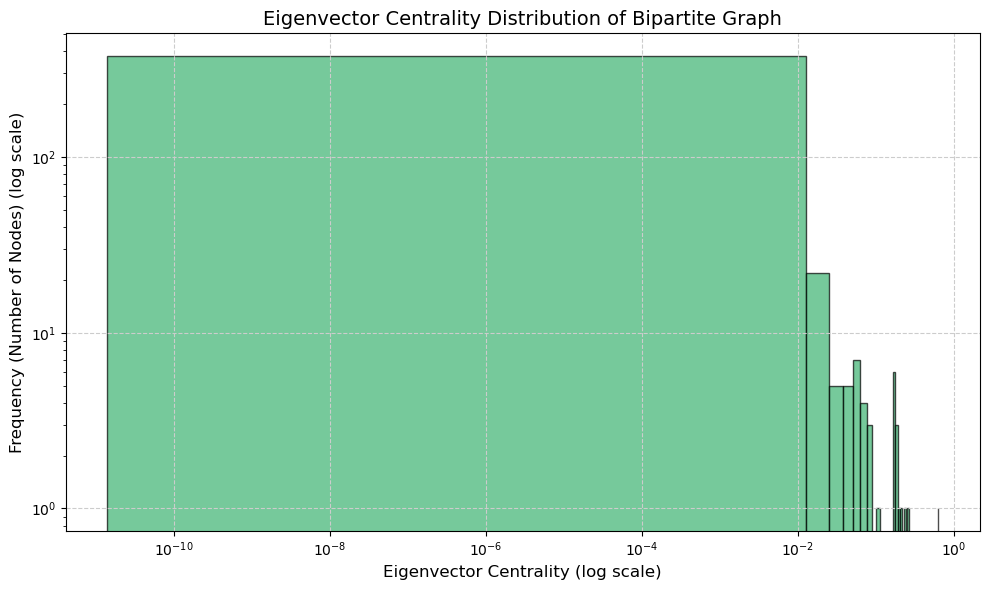


Attempting to plot a sample of the graph (N=750) with nodes colored by eigenvector centrality...
  - Drawing the entire Largest Connected Component (438 nodes).


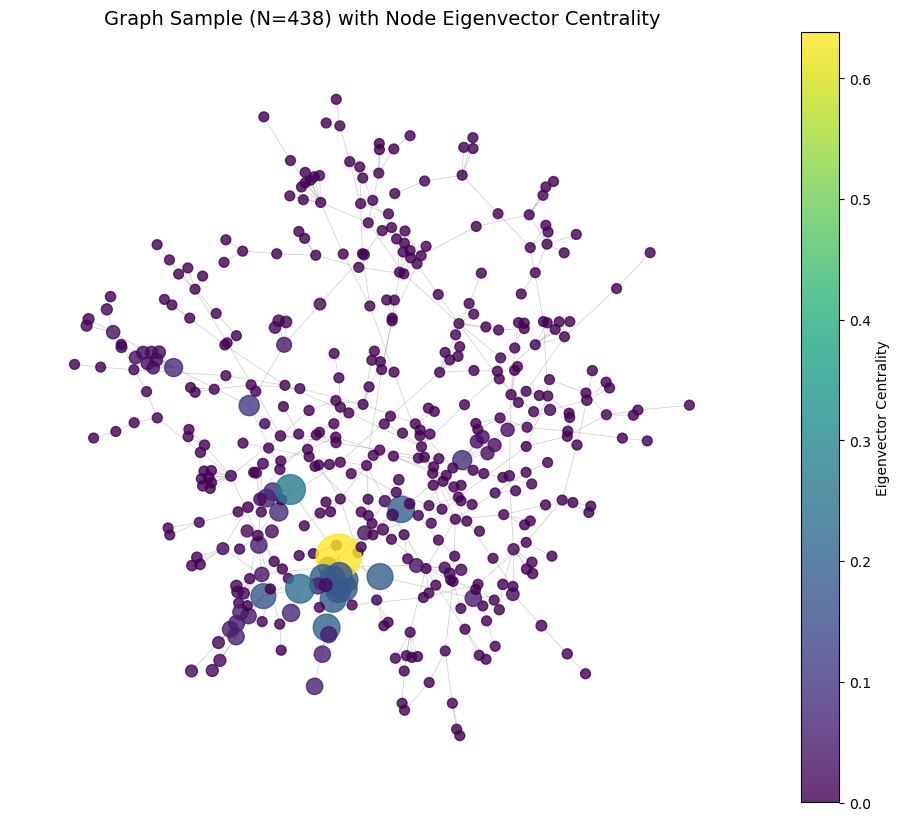

In [ ]:
plot_eigenvector_centrality(B_LCC, 
                            title="Eigenvector Centrality Distribution of Bipartite Graph",
                            plot_graph_sample=True, sample_nodes_for_draw=750, draw_layout_iterations=50)

#### Business Projection network



--- Eigenvector Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=112, Edges=195
Maximum Eigenvector Centrality: 0.390565
Minimum Eigenvector Centrality: 0.000000
Average Eigenvector Centrality: 0.034670
------------------------------------------------------------------------


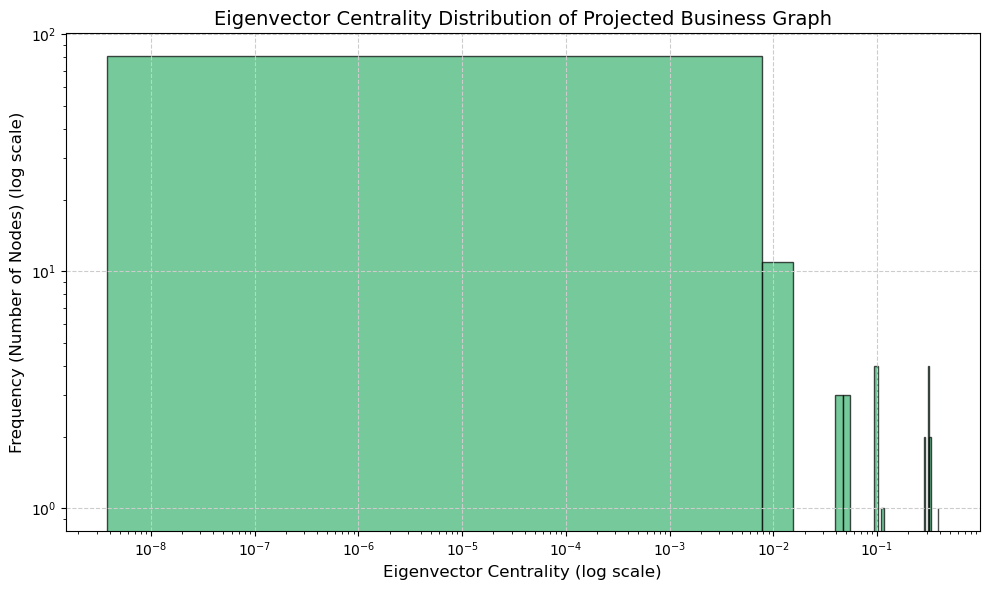


Attempting to plot a sample of the graph (N=750) with nodes colored by eigenvector centrality...
  - Drawing the entire Largest Connected Component (112 nodes).


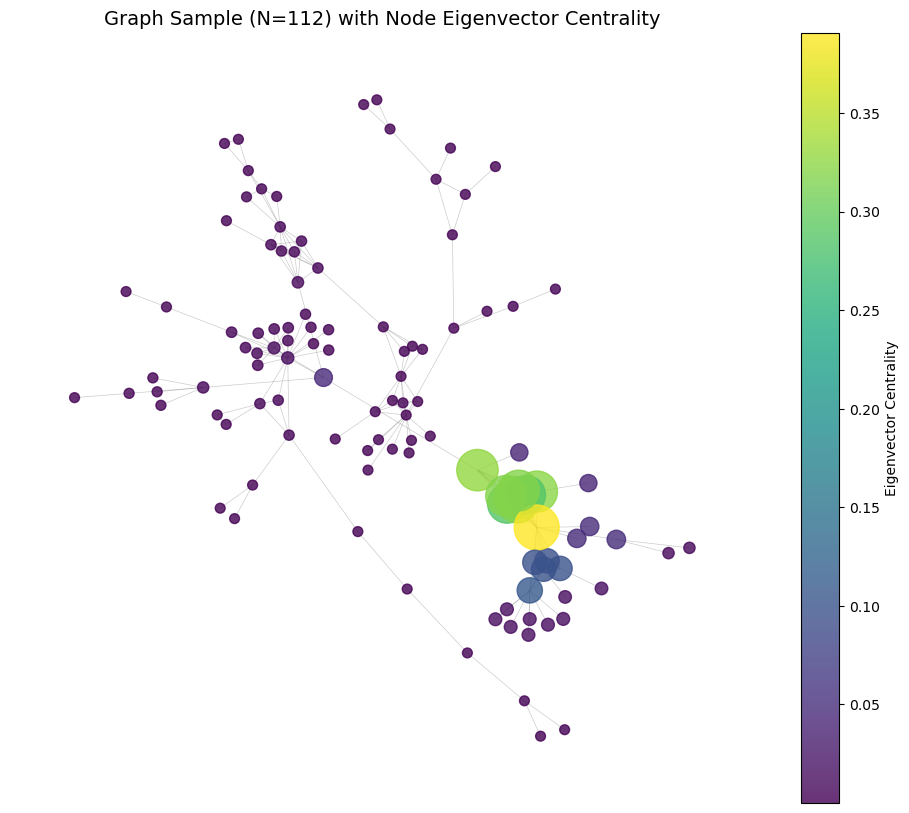

In [ ]:
plot_eigenvector_centrality(G_business_Sample_LCC, 
                            title="Eigenvector Centrality Distribution of Projected Business Graph",
                            plot_graph_sample=True, sample_nodes_for_draw=750, draw_layout_iterations=50)

#### Users Projection network


--- Eigenvector Centrality Analysis ---
Graph analyzed (LCC if disconnected): Nodes=150, Edges=289
Maximum Eigenvector Centrality: 0.428345
Minimum Eigenvector Centrality: 0.000000
Average Eigenvector Centrality: 0.027472
------------------------------------------------------------------------


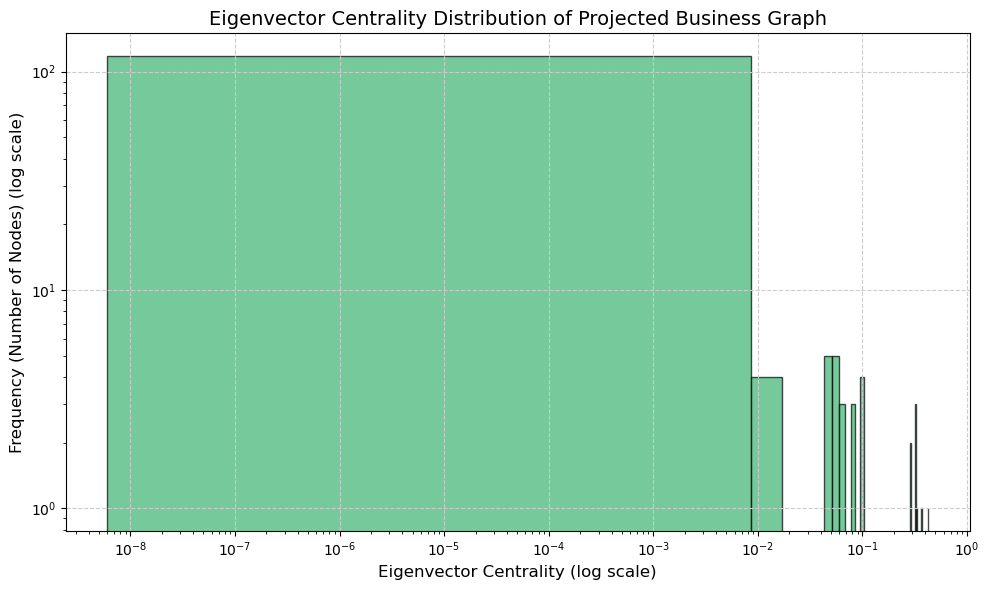


Attempting to plot a sample of the graph (N=750) with nodes colored by eigenvector centrality...
  - Drawing the entire Largest Connected Component (150 nodes).


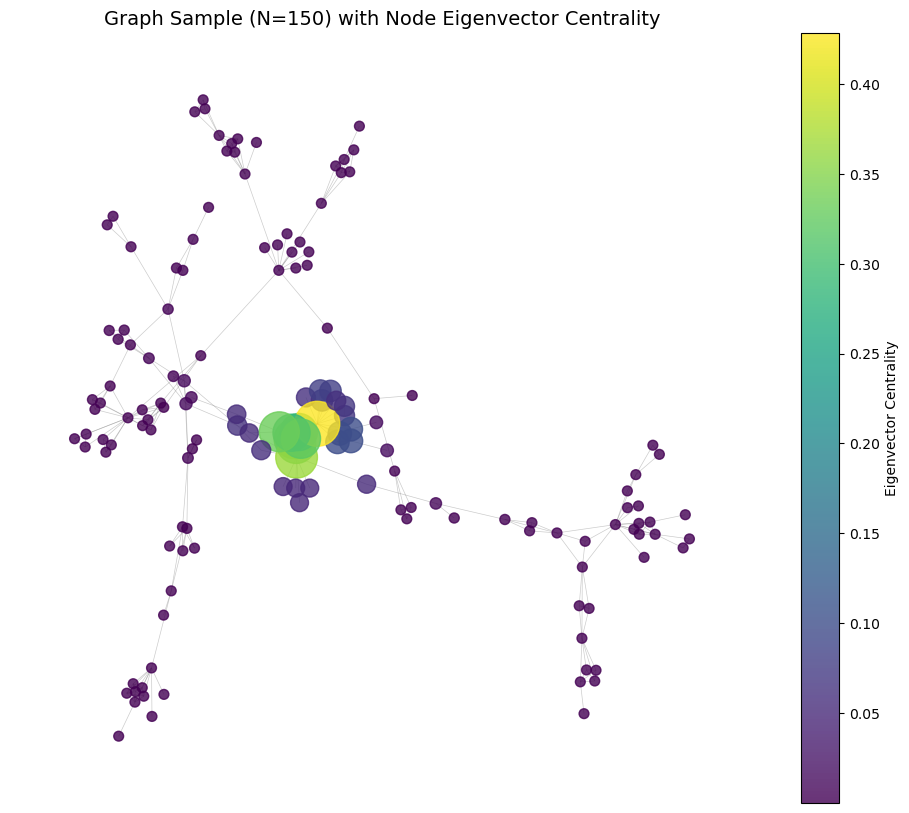

In [ ]:
plot_eigenvector_centrality(G_Users_Sample_LCC, 
                            title="Eigenvector Centrality Distribution of Projected Business Graph",
                            plot_graph_sample=True, sample_nodes_for_draw=750, draw_layout_iterations=50)

### 2.5 PageRank

In [ ]:
def plot_pagerank(G_analysis,  title="PageRank Distribution",
                plot_graph_sample=True, sample_nodes_for_draw=150, draw_layout_iterations=50):
    """
    Plots the PageRank of a graph G.
    """

    if G_analysis.number_of_nodes() == 0:
        print("Graph is empty. Cannot calculate or plot PageRank.")
        return

    # Compute PageRank
    pagerank_scores = nx.pagerank(G_analysis, alpha=0.85, max_iter=500, tol=1.0e-6)
    
    pagerank_values = list(pagerank_scores.values())

    # --- Output More Information (Statistics) ---
    if pagerank_values:
        max_pr = max(pagerank_values)
        min_pr = min(pagerank_values)
        avg_pr = sum(pagerank_values) / len(pagerank_values)
        
        print(f"\n--- PageRank Analysis ---")
        print(f"Graph analyzed (LCC if disconnected): Nodes={G_analysis.number_of_nodes()}, Edges={G_analysis.number_of_edges()}")
        print(f"Maximum PageRank: {max_pr:.6f}")
        print(f"Minimum PageRank: {min_pr:.6f}")
        print(f"Average PageRank: {avg_pr:.6f}")
        print(f"Sum of all PageRank scores: {sum(pagerank_values):.6f}")
        print(f"------------------------------------------------------------------------")
    else:
        print("\nNo PageRank values to display (e.g., LCC has no relevant structure).")
        return

    # --- Plotting the PageRank Distribution (Histogram) ---
    plt.figure(figsize=(10, 6))
    plt.hist(pagerank_values, bins=50, color='indianred', edgecolor='black', alpha=0.7)
    plt.xlabel("PageRank Score", fontsize=12)
    plt.ylabel("Frequency (Number of Nodes)(Log scale)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, which="major", ls="--", c='0.8')
    
    plt.xlim(min(pagerank_values) * 0.8 if min(pagerank_values) > 0 else 0, max(pagerank_values) * 1.2)

    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# --- Implementing nx.draw for a sample of the graph ---
    if plot_graph_sample and G_analysis.number_of_nodes() > 0:
        print(f"\nAttempting to plot a sample of the graph (N={sample_nodes_for_draw}) with nodes colored by PageRank...")

        G_draw_nodes = []
        if G_analysis.number_of_nodes() > sample_nodes_for_draw:
            G_draw_nodes = random.sample(list(G_analysis.nodes()), sample_nodes_for_draw)
            G_sample_for_draw = G_analysis.subgraph(G_draw_nodes).copy()
            print(f"  - Drawing a random sample of {sample_nodes_for_draw} nodes and their internal edges.")
        else:
            G_sample_for_draw = G_analysis
            sample_nodes_for_draw_actual = G_analysis.number_of_nodes()
            print(f"  - Drawing the entire Largest Connected Component ({sample_nodes_for_draw_actual} nodes).")

        if G_sample_for_draw.number_of_nodes() == 0:
            print("  - No nodes to draw in the selected sample/LCC.")
            return


        sample_pagerank_values = [pagerank_scores.get(node, 0) for node in G_sample_for_draw.nodes()]        
        # Scale node sizes for better visibility, handling cases of all zeros
        if sample_pagerank_values and max(sample_pagerank_values) > 0:
            max_val = max(sample_pagerank_values)
            node_sizes = [50 + 1000 * (val / max_val) for val in sample_pagerank_values]
        else:
            node_sizes = [50] * len(G_sample_for_draw.nodes())

        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G_sample_for_draw, k=0.1, iterations=draw_layout_iterations, seed=42)

        nodes = nx.draw_networkx_nodes(G_sample_for_draw, pos,
                                        node_color=sample_pagerank_values,
                                        node_size=node_sizes,
                                        cmap=plt.cm.viridis, # Another good colormap for emphasizing highs/lows
                                        alpha=0.8)
        nx.draw_networkx_edges(G_sample_for_draw, pos,
                                edge_color='gray', alpha=0.4, width=0.5)

        plt.title(f"Graph Sample (N={len(G_sample_for_draw.nodes())}) with Node PageRank", fontsize=14)        
        if nodes is not None:
            plt.colorbar(nodes, ax=plt.gca(), label="PageRank Score")
        
        plt.axis('off')
        plt.show()
    elif plot_graph_sample:
        print("\nGraph sample cannot be plotted: The graph (or LCC) is empty or too small.")

#### Sample network


--- PageRank Analysis ---
Graph analyzed (LCC if disconnected): Nodes=4199, Edges=3100
Maximum PageRank: 0.001593
Minimum PageRank: 0.000058
Average PageRank: 0.000238
Sum of all PageRank scores: 1.000000
------------------------------------------------------------------------


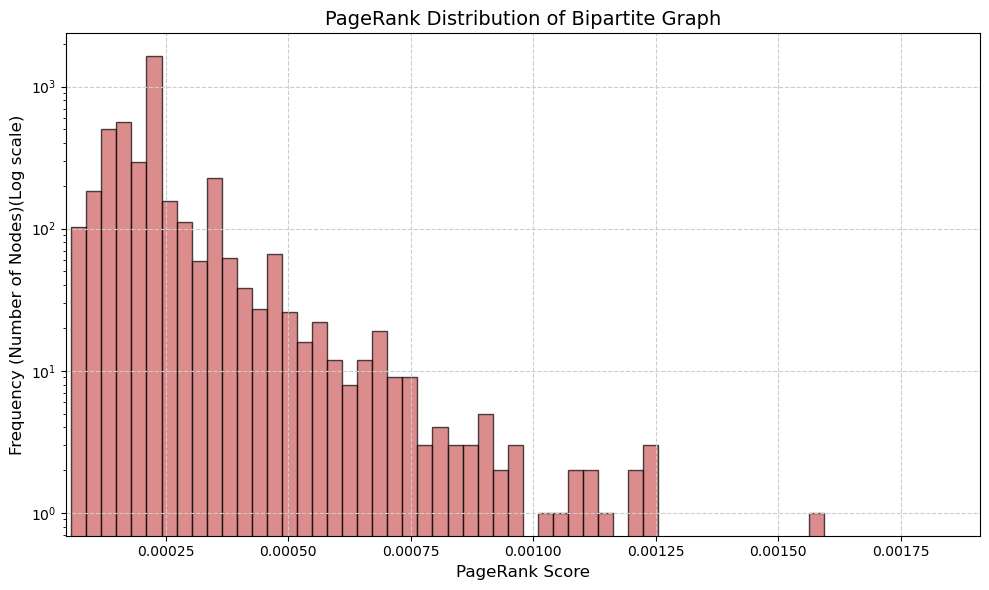


Attempting to plot a sample of the graph (N=500) with nodes colored by PageRank...
  - Drawing a random sample of 500 nodes and their internal edges.


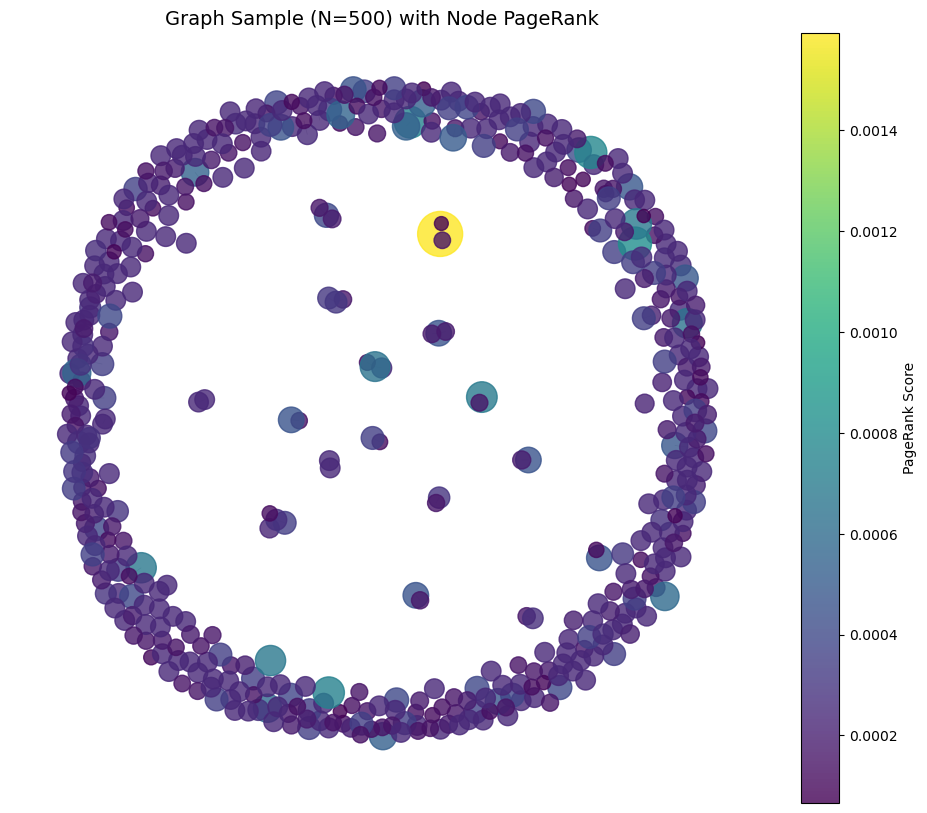

In [ ]:
plot_pagerank(B, title="PageRank Distribution of Bipartite Graph",
                plot_graph_sample=True, sample_nodes_for_draw=500, draw_layout_iterations=50)

#### Business Projection network


--- PageRank Analysis ---
Graph analyzed (LCC if disconnected): Nodes=112, Edges=195
Maximum PageRank: 0.051297
Minimum PageRank: 0.002555
Average PageRank: 0.008929
Sum of all PageRank scores: 1.000000
------------------------------------------------------------------------


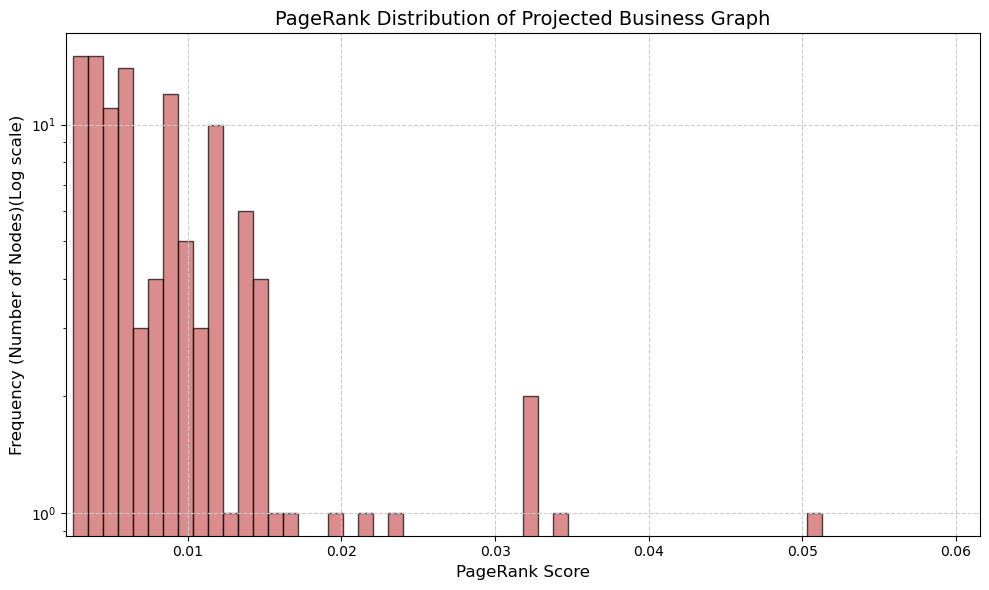


Attempting to plot a sample of the graph (N=500) with nodes colored by PageRank...
  - Drawing the entire Largest Connected Component (112 nodes).


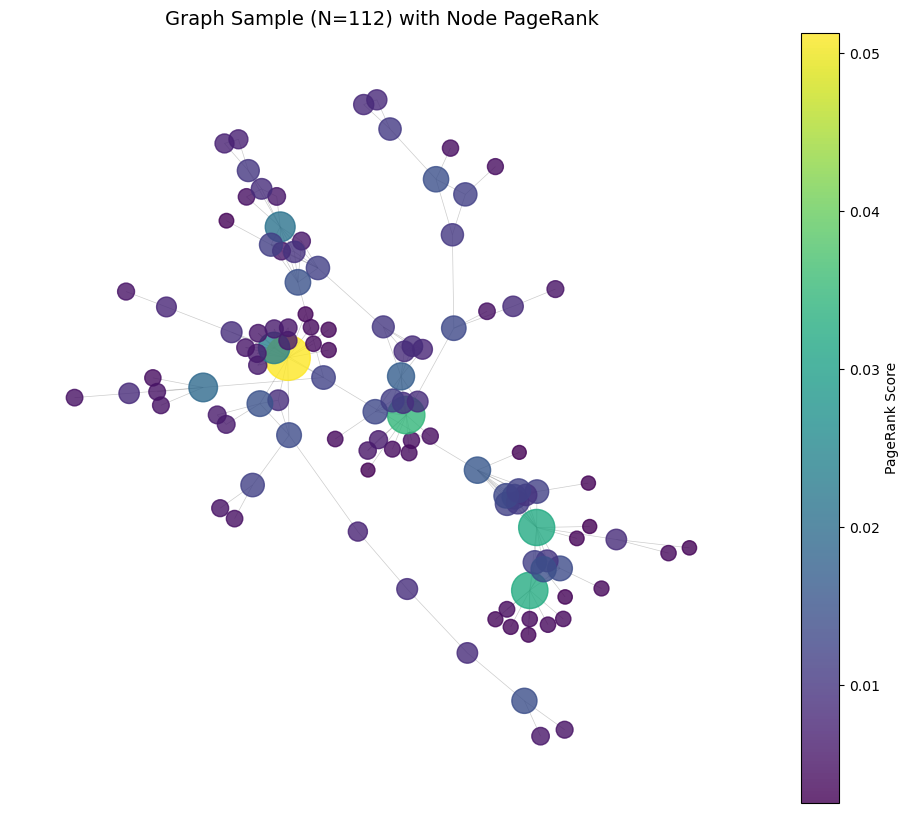

In [ ]:
plot_pagerank(G_business_Sample_LCC, title="PageRank Distribution of Projected Business Graph",
                plot_graph_sample=True, sample_nodes_for_draw=500, draw_layout_iterations=50)

#### Users Projection network



--- PageRank Analysis ---
Graph analyzed (LCC if disconnected): Nodes=150, Edges=289
Maximum PageRank: 0.028955
Minimum PageRank: 0.001821
Average PageRank: 0.006667
Sum of all PageRank scores: 1.000000
------------------------------------------------------------------------


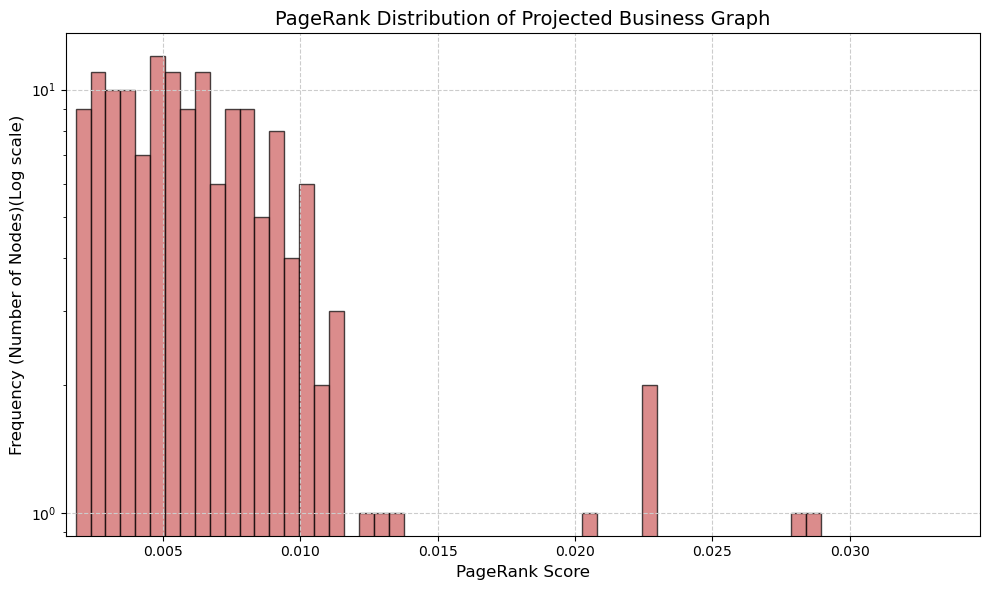


Attempting to plot a sample of the graph (N=500) with nodes colored by PageRank...
  - Drawing the entire Largest Connected Component (150 nodes).


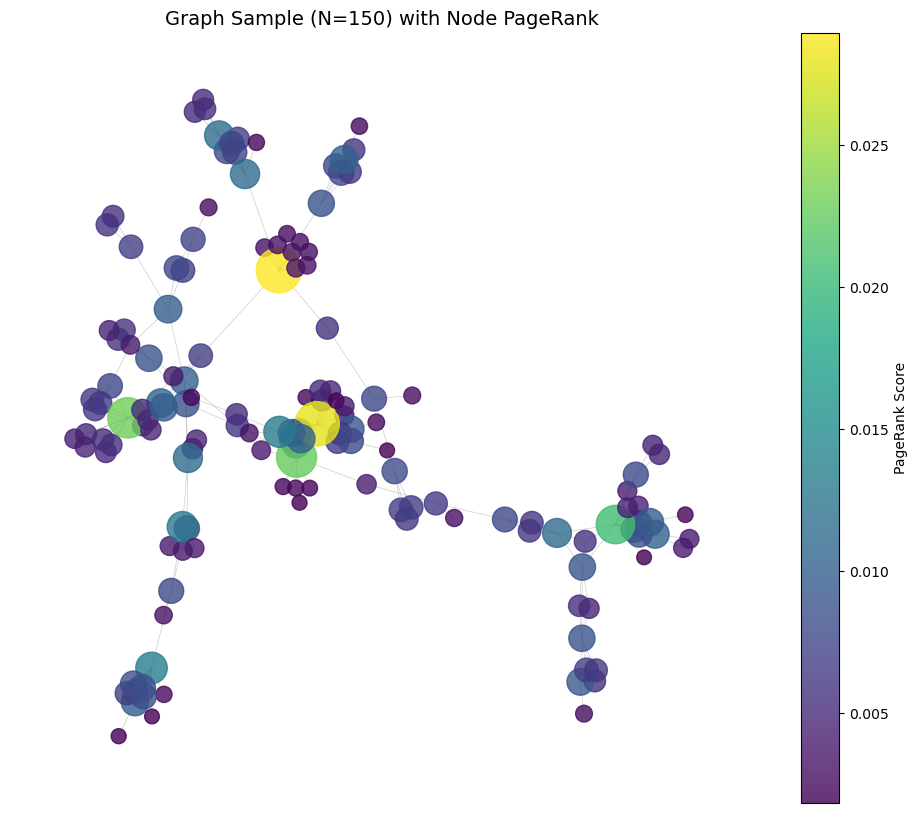

In [ ]:
plot_pagerank(G_Users_Sample_LCC, title="PageRank Distribution of Projected Business Graph",
                plot_graph_sample=True, sample_nodes_for_draw=500, draw_layout_iterations=50)

### 2.6  Power Law

In [ ]:
def plot_power_law_distribution(G, title="Power Law Distribution"):
    """
    Plots the degree distribution of a graph G on a log-log scale to check for power law behavior.
    """
    if G.number_of_nodes() == 0:
        print("Graph is empty. Cannot analyze power law.")
        return
    # Get the degree sequence
    degree_sequence = [d for n, d in G.degree()]
    
    # np.unique returns sorted unique elements and their counts
    degrees, counts = np.unique(degree_sequence, return_counts=True)
    
    non_zero_degrees_mask = (degrees > 0) & (counts > 0)
    filtered_degrees = degrees[non_zero_degrees_mask]
    filtered_counts = counts[non_zero_degrees_mask]
    
    if len(filtered_degrees) < 2:
        print("Not enough unique non-zero degrees to perform a power law fit.")
        print("At least two distinct non-zero degree values are required.")
        return
    
    #Log-transform the filtered data
    log_degrees = np.log10(filtered_degrees)
    log_counts = np.log10(filtered_counts)
    
    # Perform Linear Regression on the log-transformed data
    # The slope of this line will be -alpha
    slope, intercept, r_value, p_value, std_err = linregress(log_degrees, log_counts)
    
    # Calculate alpha (the power-law exponent)
    alpha = -slope
    
    # Calculate R-squared (coefficient of determination)
    r_squared = r_value**2
    
    print(f"\n--- Power Law Analysis ---")
    print(f"Estimated Power-Law Exponent (alpha): {alpha:.4f}")
    print(f"R-squared value (Goodness of Fit): {r_squared:.4f}")
    print(f"Slope of log-log fit: {slope:.4f}")
    print(f"Intercept of log-log fit: {intercept:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Standard Error: {std_err:.4f}")
    
    # Plotting the degree distribution and the fitted line
    plt.figure(figsize=(10, 7))
    
    plt.plot(filtered_degrees, filtered_counts, 'o',
            markersize=6, alpha=0.7, color='darkblue',
            label='Degree Distribution')
    # Plot the fitted power law line
    fitted_line_log = slope * log_degrees + intercept
    plt.plot(filtered_degrees, 10**fitted_line_log, 
            linestyle='--', 
            color='red',
            label=f'Fitted Power Law ($\\alpha$={alpha:.2f}, $R^2$={r_squared:.2f})')
    
    # Set log scales for both x and y axes
    plt.xscale('log')
    plt.yscale('log')    
    
    # Add labels, title, and grid
    plt.xlabel("Degree (k)", fontsize=12)
    plt.ylabel("Number of Nodes (N_k)", fontsize=12)
    plt.title("Degree Distribution with Power Law Fit", fontsize=14)
    plt.grid(True, which="both", ls="--", c='0.7', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Adjust x-axis limits for better visualization
    # Ensure min limit is > 0 for log scale
    min_x_lim = max(1, filtered_degrees.min() * 0.8)
    max_x_lim = filtered_degrees.max() * 1.2
    plt.xlim(min_x_lim, max_x_lim)

    plt.tight_layout()
    plt.show()

#### Sample network


--- Power Law Analysis ---
Estimated Power-Law Exponent (alpha): 3.0871
R-squared value (Goodness of Fit): 0.9810
Slope of log-log fit: -3.0871
Intercept of log-log fit: 3.7174
P-value: 0.0000
Standard Error: 0.1294


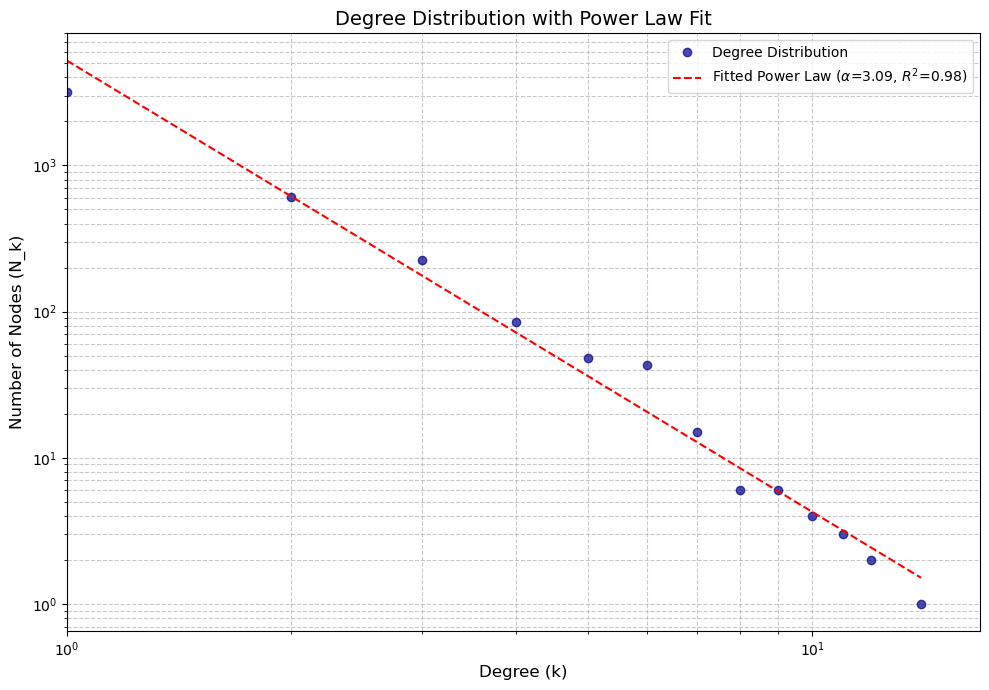

In [ ]:
plot_power_law_distribution(B)

#### Business Projection network


--- Power Law Analysis ---
Estimated Power-Law Exponent (alpha): 2.3562
R-squared value (Goodness of Fit): 0.9279
Slope of log-log fit: -2.3562
Intercept of log-log fit: 3.2909
P-value: 0.0000
Standard Error: 0.1642


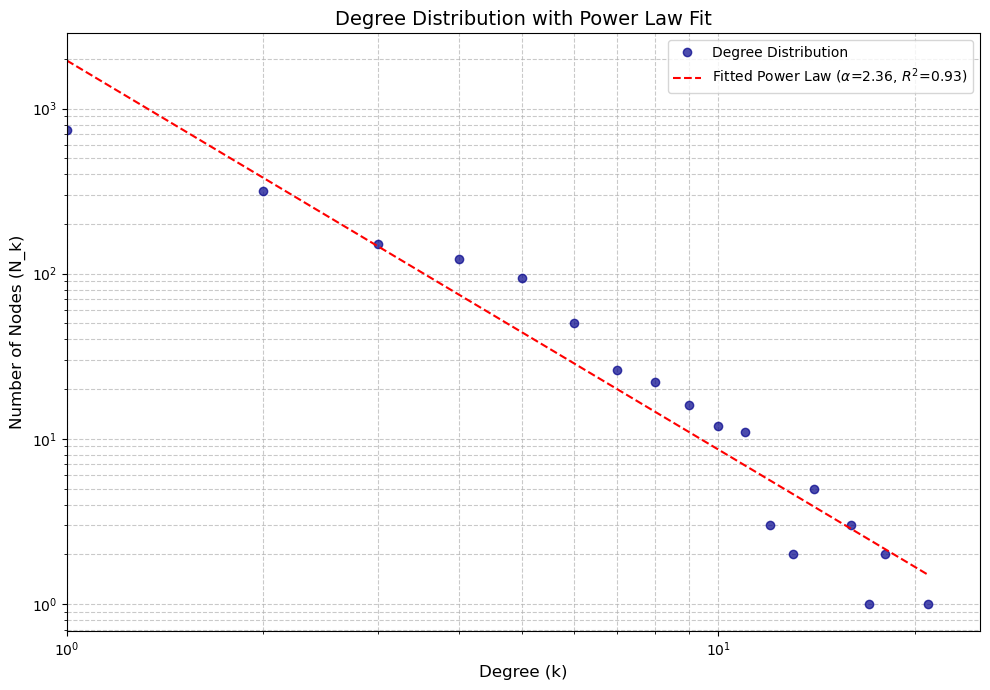

In [ ]:
plot_power_law_distribution(G_business_Sample)

#### Users Projection network


--- Power Law Analysis ---
Estimated Power-Law Exponent (alpha): 2.2309
R-squared value (Goodness of Fit): 0.8767
Slope of log-log fit: -2.2309
Intercept of log-log fit: 3.4181
P-value: 0.0000
Standard Error: 0.2091


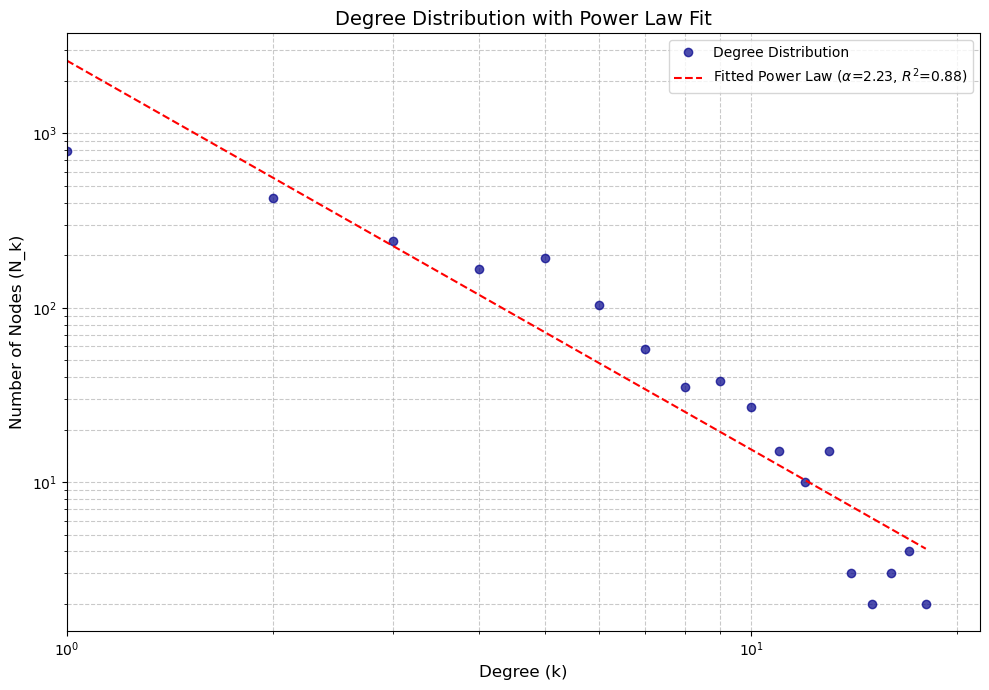

In [ ]:
plot_power_law_distribution(G_Users_Sample)